# **Dataset & Description**



[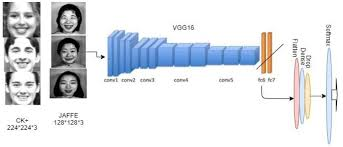](http://)


The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.








[Dataset link ](https://www.kaggle.com/msambare/fer2013)

# Import necessary python libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sn
# import skimage.io
# import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
# from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

2022-12-07 15:35:38.334579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 15:35:38.442169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-12-07 15:35:38.442185: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-07 15:35:38.461229: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-07 15:35:38.988096: W 

# Data Preprocessing

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = '../Dataset/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64,
                                                   shuffle = True)

Found 22968 images belonging to 7 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../Dataset/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [5]:
test_dataset = test_datagen.flow_from_directory(directory = '../Dataset/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [6]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

2022-12-07 15:35:40.823833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-12-07 15:35:40.824464: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-07 15:35:40.824568: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (unmanned-arena): /proc/driver/nvidia/version does not exist
2022-12-07 15:35:40.835229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [8]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [9]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [10]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = 20,
                        verbose = 1,
                        factor = 0.50,
                        min_lr = 1e-10
                        )

mcp = ModelCheckpoint('Models/cb_vgg16.h5',
                        monitor='val_acc')

es = EarlyStopping(verbose=1,
                        patience=20,
                        restore_best_weights=True #restoring the best model
                        )

In [11]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 100,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/100
359/359 [==============================] - 740s 2s/step - loss: 1.9400 - accuracy: 0.1981 - val_loss: 1.8111 - val_accuracy: 0.2480 - lr: 0.0010
Epoch 2/100
359/359 [==============================] - 333s 927ms/step - loss: 1.8233 - accuracy: 0.2358 - val_loss: 1.8068 - val_accuracy: 0.2595 - lr: 0.0010
Epoch 3/100
359/359 [==============================] - 335s 933ms/step - loss: 1.7615 - accuracy: 0.2760 - val_loss: 1.7289 - val_accuracy: 0.2935 - lr: 0.0010
Epoch 4/100
359/359 [==============================] - 315s 878ms/step - loss: 1.7362 - accuracy: 0.2917 - val_loss: 1.7149 - val_accuracy: 0.2982 - lr: 0.0010
Epoch 5/100
359/359 [==============================] - 315s 878ms/step - loss: 1.7149 - accuracy: 0.3004 - val_loss: 1.7128 - val_accuracy: 0.2984 - lr: 0.0010
Epoch 6/100
359/359 [==============================] - 454s 1s/step - loss: 1.6958 - accuracy: 0.3088 - val_loss: 1.6325 - val_accuracy: 0.3280 - lr: 0.0010
Epoch 7/100
359/359 [=========================

In [13]:
model.save('Models/vgg16_v1.h5')

# Data Postprocessing

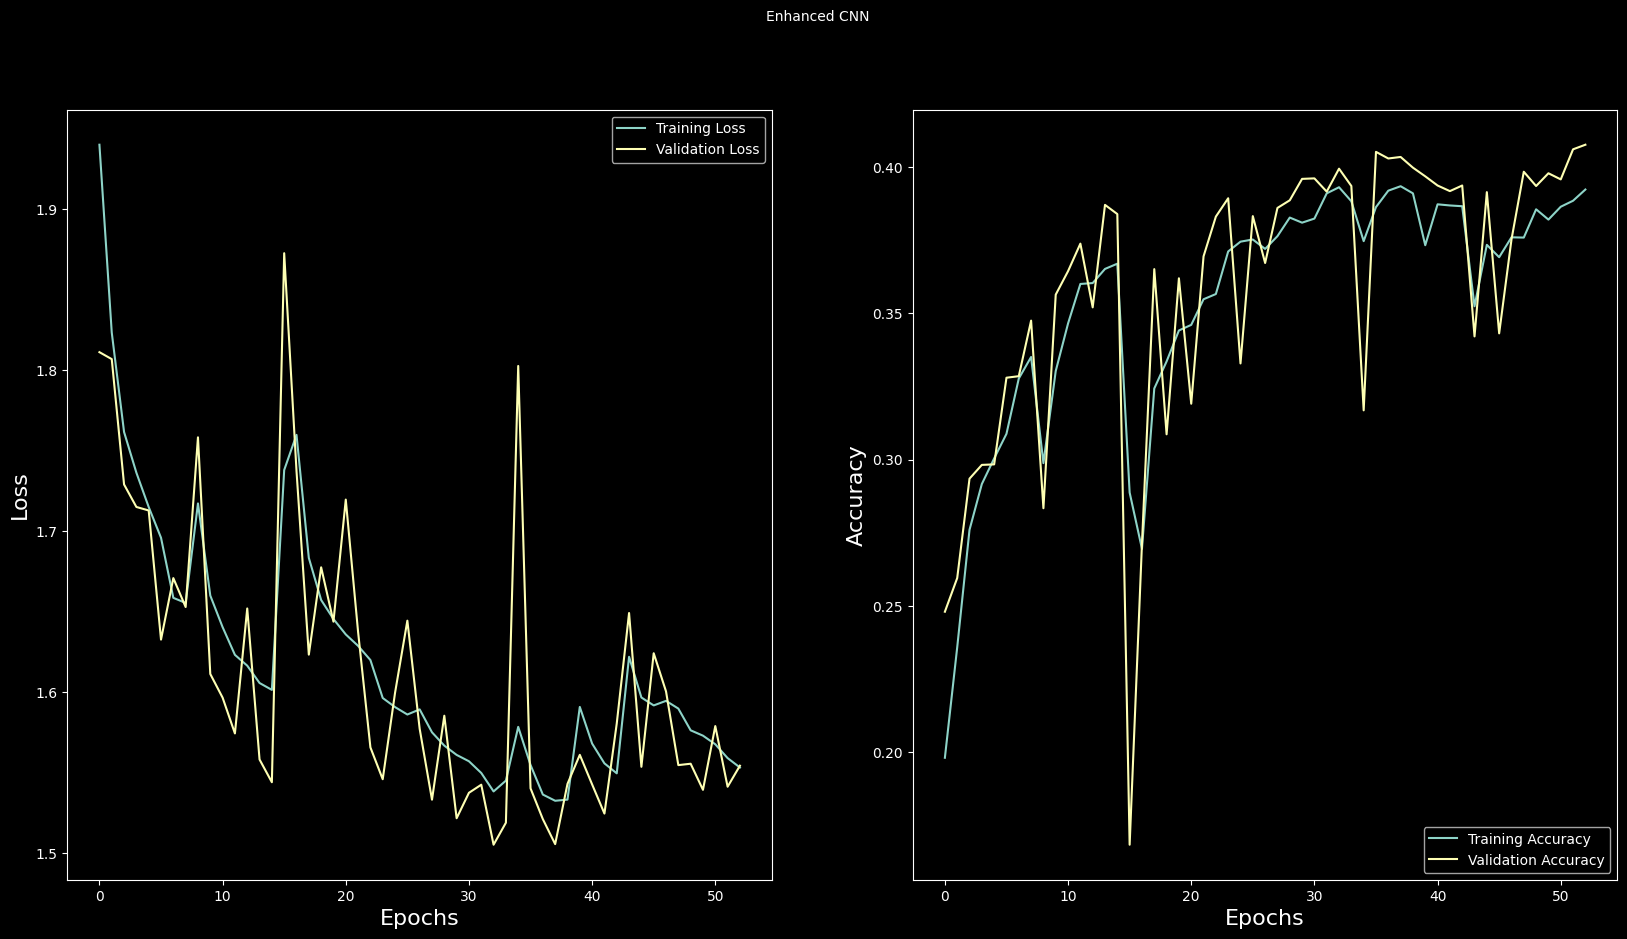

In [14]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Enhanced CNN', fontsize=10)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Load a model

In [15]:
from tensorflow.keras.models import load_model

model = load_model('Models/vgg16_v1.h5', compile = True)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

# Test a model

In [17]:
results = model.evaluate(test_dataset)
results

113/113 [==============================] - 130s 1s/step - loss: 1.4977 - accuracy: 0.4074


[1.4976590871810913, 0.40735581517219543]

# Create Confusion Matrix

In [18]:
# Finding prediction for the test dataset
predictions = model.predict(test_dataset)

# Categorizing test dataset based on predictions
test_prediction = []
for i in range(test_dataset.samples):
    idx = np.argmax(predictions[i])
    test_prediction.append(idx)

113/113 [==============================] - 38s 332ms/step


In [19]:
# Defining labels of Confusion Matrix
emotions = test_dataset.class_indices

# Creating Confusion matrix
res = tf.math.confusion_matrix(test_prediction, test_dataset.classes).numpy()
cm = pd.DataFrame(res, index=emotions, columns=emotions)
cm

,angry,disgust,fear,happy,neutral,sad,surprise
angry,0,0,0,0,0,0,0
disgust,0,0,0,0,0,0,0
fear,97,10,80,143,116,114,86
happy,345,37,382,700,458,473,292
neutral,61,1,66,90,82,73,53
sad,286,41,315,529,383,361,252
surprise,169,22,181,312,194,226,148
